# Description
Inside `get_covmats/power_covmat_densitybins.py` is the code to compute the 2D power spectrum for each density bin for a large number (about 1600) of small BGS boxes of size $500$ Mpc/h. The data is stored in `/density_splits`. This power spectrum and the inferred multipoles are then used to compute the covariance matrix for each density bin by brute force. The results are stored in `/covariance_matricies`. Since each box takes about 1 minute to compute (at Nmesh=128), this task is submit as a job to Cuillin with an estimated run time of 20.5 hours.


The above computations consider $k \in (0,1.4)$. This allows to slice the covariance matrix down when only considering linear theory. This and how to visualize the covariance and correlation matrix will be shown below. Recall the form of the covariance matrix:
$$
C=\begin{bmatrix} C_{00} & C_{02} \\ C_{20} & C_{22}\end{bmatrix}
$$

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from nbodykit.lab import FFTPower
from nbodykit import style
plt.style.use(style.notebook)

In [4]:
# values of s the same for all boxes and bins. just extract from one
r = FFTPower.load('/home/jwack/main/fitmodel_densitysplit/bruteforce_covmat/density_splits/BGS_box_ph3000/power_ptile_4.json')
k = r.poles['k']

In [5]:
# load covariance matrix of one density bin
large_covmat = np.loadtxt('/home/jwack/main/fitmodel_densitysplit/bruteforce_covmat/covariance_matricies/cov_ptile_9.txt')

### Modes
Recall the definitionof the power spectrum (or see Hamilton eq 3.3, 3.5): 

The Fourier mode $\hat{\delta}(k)$ is defined as the Fourier transform of the over-density $\delta(r)$. The variance of the over-density is defined as the two point correlation function which, since $\langle \delta(r) \rangle = 0$ by construction, reduced to $\zeta(r_{12}) = \langle \delta(r_1) \delta(r_2) \rangle$. Similarly, the power spectrum is defined as the variance of the Fourier modes: $\langle \hat{\delta}(k_1) \hat{\delta}(k_2) \rangle = (2\pi)^3 \delta_D(k_1-k_2)P(k_1)$. 

Hence, when binning the power spectrum in k, a certain number of Fourier modes will be averaged over for each k bin. This number is stored in `r.poles['modes']`. As the BoxSize of $500 Mpc/h$ is quite small, only density bins with $k<1.4$ have a non zero number of modes. Consequently, for all higher k bins the power cannot be computed such that it is left as `NaN`. Hence, we can only use `[:140]` for the analysis. Since this issue is due to the BoxSize only, it occurs for all boxes and density bins.

### First k bin
Further note that the 2D power spectrum in the first k bins vanishes for all $\mu$. Hence all multipoles vanishes as well (since they are just the projection of the 2D spectrum on Legendre polynomials). As the shotnoise is only subtracted from the monopole, just the higher multipoles remain zero in the first k bin. Hence the rows and columns of the covariance matrix with index `n*len(k)` for $n=1,2, ...$ are zero. The zero diagonal element causes a divide by 0 error when computing the correlation matrix. To avoid this, we set the diagonal element to a small, non zero value: `cov_mat[len(k)][len(k)] = cov_mat[len(k)][len(k)] + 1e-10 # when ells = [0,2,4] need to repeat at 2*len(k)` or ignore it from the analysis for now. A further alternative would be to use the analytic result for the first k bin.

This issues doesn't appear in the multipoles of the measurement simulation. As the same `Nmesh=128` was used, but the BoxSize is 4 times bigger (500 Mpc/h vis 2000 Mpc/h) this suggests the above addressed issue is purely a result of the mesh and FFT nuisance parameters. 

### Sample volume effect on errors
Further observe that the BoxSize difference implies that on has to scale the covariance matrix by $\frac{1}{4^3}$.

In [6]:
def slice_covmat(cov_mat, k, kmax):
    '''Slices down full covariance matrix to k<=kmax<2 under the assumption that ells = [0,2].
    The first k bin will be also be sliced away as the quadrupole vanishes in that bin, leading to a divide by 0 error 
    when computing the correlation matrix.'''    
    k_slice = (k <= kmax)
    k_slice[0] = False # remove problematic first bin from analysis
    new_size = int(2*np.sum(k_slice)) # slices matrix will be of shape (new_size, new_size) 
    mask = np.concatenate((k_slice, k_slice)) # when ells = [0,2,4] concatenate 3 times
    mat_mask = np.outer(mask, mask) 
    
    return np.reshape(cov_mat[mat_mask], (new_size, new_size))
    
    
def show_covmat(cov_mat):    
    sig = np.sqrt(np.diag(cov_mat))
    cor_mat = cov_mat / np.outer(sig,sig)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
    
    cov_plot = ax1.matshow(cov_mat)
    plt.colorbar(cov_plot, ax=ax1)
    ax1.set_title('Covariance matrix')

    cor_plot = ax2.matshow(cor_mat)
    plt.colorbar(cor_plot, ax=ax2)
    ax2.set_title('Correlation matrix')
    
    plt.show()

In [ ]:
covmat_sliced = slice_covmat(large_covmat, k, 0.4)
show_covmat(covmat_sliced)

### Interpretation
- low density: Anti-correlation between multipoles at low k is surprising and confined to the diagonal (different k bins independent of each other)
- mid density: as expected: strong correlation along diag and noise in off diags
- high density: auto correlation of a multipole: off diagonal correlation increase with k meaning that value of monopole or dipole in a high k bin depends on the value of the monopole or dipole in the neighboring k bins. The correlation between mono and quadrupole also interesting as they are large independent as small k but become anti-correlated at larger k. Again, k bins are not independent anymore.

# Make comparison plot between analytic and brute force correlation matrix
Choose a representative medium density bin

In [7]:
from scipy.special import legendre
from scipy.integrate import simpson
import scipy.sparse as ss

In [8]:
def per_mode_cov(k, l1, l2, BoxSize, shotnoise, dk, Pkmu, mus):
    '''Construct per mode covariance. See eq 15, 16 (for factor f) of Grieb et al. 2016: https://arxiv.org/pdf/1509.04293.pdf
    Pkmu is a 2D array of shape (# k bins, # mu bins). The above paper presents two possible choices in eq 23, 24 with the former 
    being based on the model and later based on the data.'''
    V = BoxSize**3
    V_k = 4/3*np.pi*((k+dk/2)**3 - (k-dk/2)**3)
    f = 2*(2*np.pi)**4 / V_k**2 * k**2 * dk
    
    L_l1, L_l2 = legendre(l1)(mus), legendre(l2)(mus)
    integrand = (Pkmu + shotnoise)**2 * L_l1*L_l2
    
    return f*(2*l1+1)**2 * (2*l2+1)**2 / V * simpson(integrand, mus) # 1D array containing per mode cov for each k bin


def gaussian_covmat(k, ells, BoxSize, shotnoise, dk, Pkmu, mus):
    '''See Grieb et al. 2016: https://arxiv.org/pdf/1509.04293.pdf or Fitting_b1_different_kmax.ipynb for explanation of structure of 
    covariance matrix. Uses sparse matricies for fast inversion.
    scipy.sparse.bmat allows to combine matricies by passing structure of larger matrix in terms of submatricies.'''
    # initialize array accepting matricies as elements and fill with diagonal C_l1,l2 matricies
    C = np.empty((len(ells), len(ells)), dtype='object')
    for i,l1 in enumerate(ells):
        for j,l2 in list(enumerate(ells))[i:]:
            C[i][j] = ss.diags(per_mode_cov(k,l1,l2,BoxSize,shotnoise,dk,Pkmu,mus))
            if j!=i:
                C[j][i] = C[i][j]
                
    cov_mat = ss.bmat(C).tocsc() # convert to efficient scipy matrix format
    
    return cov_mat.toarray()

In [26]:
ptile_idx = 0
kmax = 0.225
ells = [0,2]

# get analytic correlation using data P(k,mu)
r = FFTPower.load('/home/jwack/main/fitmodel_densitysplit/power_densitybins/ptile_%d.json'%ptile_idx)
poles = r.poles 
k_full = poles['k']    
mus = r.power.coords['mu']

mask = np.full(len(k_full), False)
mask = k_full <= kmax
mask[0] = False 
k_sliced = k_full[mask]

Pk_0, Pk_2 = r.poles['power_0'].real-r.attrs['shotnoise'], r.poles['power_2'].real
Pkmu_data = (np.outer(Pk_0, legendre(0)(mus)) + np.outer(Pk_2, legendre(2)(mus)))[mask]

analytic_covmat = gaussian_covmat(k_sliced, ells, 2000, r.attrs['shotnoise'], 0.01, Pkmu_data, mus)
sig = np.sqrt(np.diag(analytic_covmat))
analytic_cormat = analytic_covmat / np.outer(sig,sig)

# get brute force correlation
brute_covmat_full = np.loadtxt('/home/jwack/main/fitmodel_densitysplit/bruteforce_covmat/covariance_matricies/cov_ptile_%d.txt'%ptile_idx)
brute_covmat = 1/4**3 * slice_covmat(brute_covmat_full, k_full, kmax)
sig = np.sqrt(np.diag(brute_covmat))
brute_cormat = brute_covmat / np.outer(sig,sig)

/tmp/ipykernel_4065051/871083733.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(brute_plot, cax=cbar_ax)


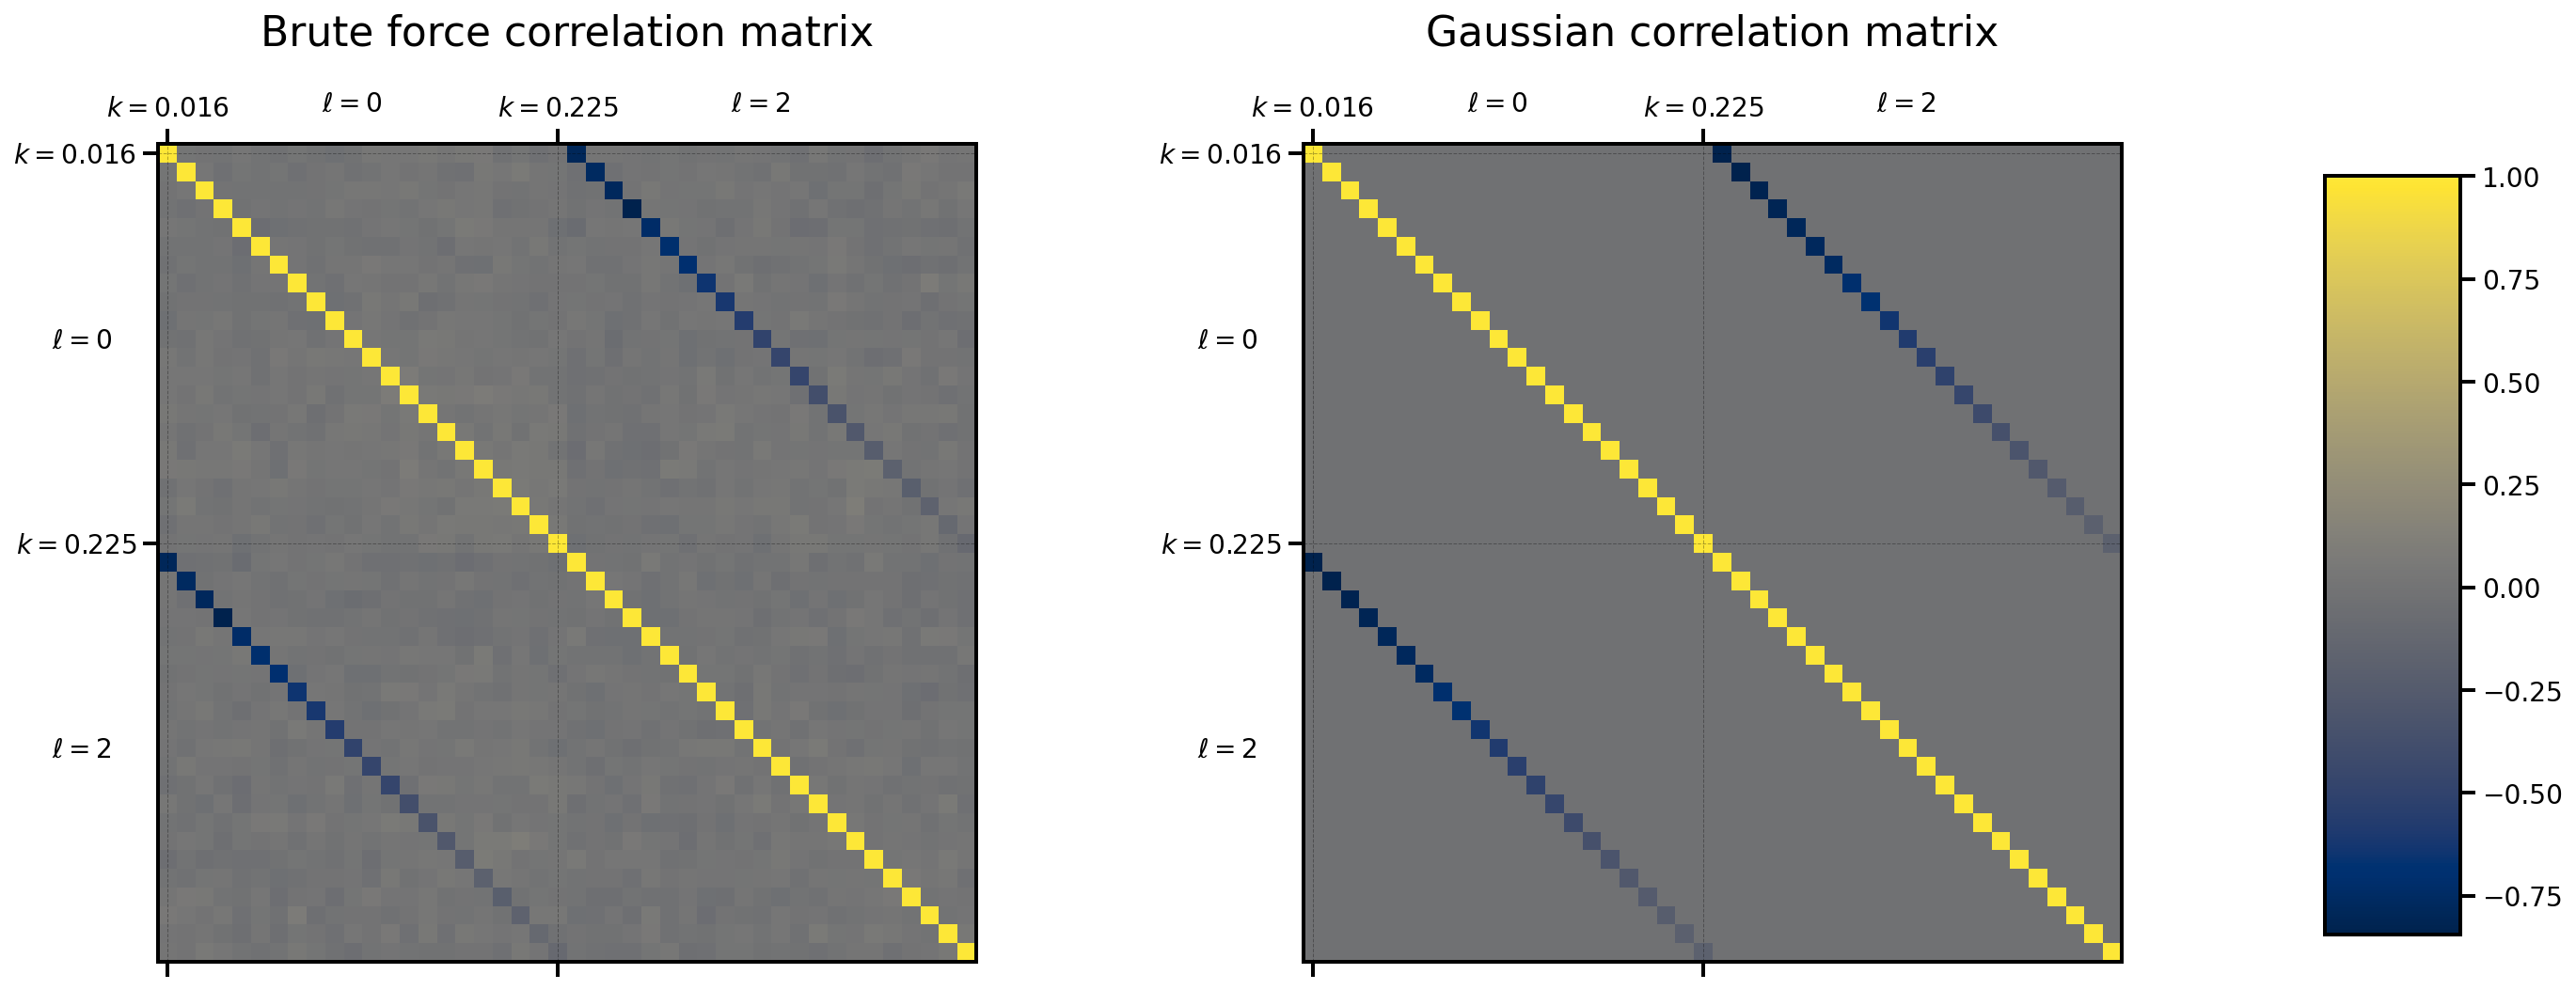

In [30]:
fig, axs = plt.subplots(1,2, figsize=(20,8))

brute_plot = axs[0].matshow(brute_cormat, cmap='cividis')
axs[0].set_title('Brute force correlation matrix', pad=27)

analytic_plot = axs[1].matshow(analytic_cormat, cmap='cividis')
axs[1].set_title('Gaussian correlation matrix', pad=27)

for i in [0,1]:
    labels = [r'$k=%.3f$'%k_sliced[0], r'$k=%.3f$'%k_sliced[-1]]
    axs[i].set_xticks([0, len(k_sliced)-1], labels=labels)
    axs[i].annotate(r'$\ell=0$', (0.2, 1.04), xycoords='axes fraction')
    axs[i].annotate(r'$\ell=2$', (0.7, 1.04), xycoords='axes fraction')
    
    axs[i].set_yticks([0, len(k_sliced)-1], labels=labels)
    axs[i].annotate(r'$\ell=0$', (-0.13, 0.75), xycoords='axes fraction')
    axs[i].annotate(r'$\ell=2$', (-0.13, 0.25), xycoords='axes fraction')


cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(brute_plot, cax=cbar_ax)

plt.show()
#fig.savefig('brute_vs_analytic%d.pdf'%ptile_idx)